# Project2 - Stock Market Prediction

By Amit Moshe & Inbar Roth

## Imports

In [5]:
#for preprocess:
import nltk
#nltk.download()
import string
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
stopWords=(stopwords.words('english'))
import pandas as pd
import numpy as np
import sklearn.datasets as sk
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import itertools  
import json

In [6]:
#for ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm
from sklearn.metrics import accuracy_score

In [7]:
#deep learning model imports:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import Adam as adam

## Data Collection:

In [8]:
# read data
data_df = pd.read_csv("C:\\Users\\Inbar\\Documents\\סמסטר ז'\\היבטים מעשיים בכריית תוכן\\פרויקט\\Data\\Combined_News_DJIA.csv")

## Preprocess:

In [9]:
# preprocess
def preprocessing(text):
    text = str(text)
    #some of the news starts with b' or b":
    if text.startswith("b\"") or text.startswith("b\'"):
        text = text[1:]
    text = text.replace("\"", "").replace("\'", "")
    # lower case the text
    text = text.lower()
    # tokenize the text
    sentence = word_tokenize(text)
    # stemming
    ps = PorterStemmer()
    sentence=[ps.stem(word) for word in sentence]
    # remove stop words
    sentence = [w for w in sentence if len(w)>1]
    sentence = [w for w in sentence if not w in stopWords]
    final_text= " ".join(sentence)
    return final_text.strip()

In [10]:
#preprocess the top news 
titles = data_df.columns[range(2, 27)]
data_df[titles] = data_df[titles].applymap(preprocessing)

#### Explore data:

In [11]:
labels=data_df['Label']
classCounter = {}
classCounter[0]=0
classCounter[1]=0
for label in labels:
    classCounter[label]+=1
print("class distribution:")
pd.DataFrame.from_dict(classCounter,orient='index',columns=['number of Samples'])

class distribution:


,number of Samples
0,924
1,1065


In [12]:
#build dictionary of class:{term:frequency}
terms_dict={}
terms_dict[0]={}
terms_dict[1]={}
for index, row in data_df.iterrows():
    label=row['Label']
    news=row[titles]
    for article in news:
        tokens=word_tokenize(article)
        for token in tokens:
            if token not in terms_dict[label]:
                terms_dict[label][token]=0
            terms_dict[label][token]+=1
label_0={key: value for key, value in sorted(terms_dict[0].items(), key=lambda item: item[1],reverse=True)}
label_1={key: value for key, value in sorted(terms_dict[1].items(), key=lambda item: item[1],reverse=True)}

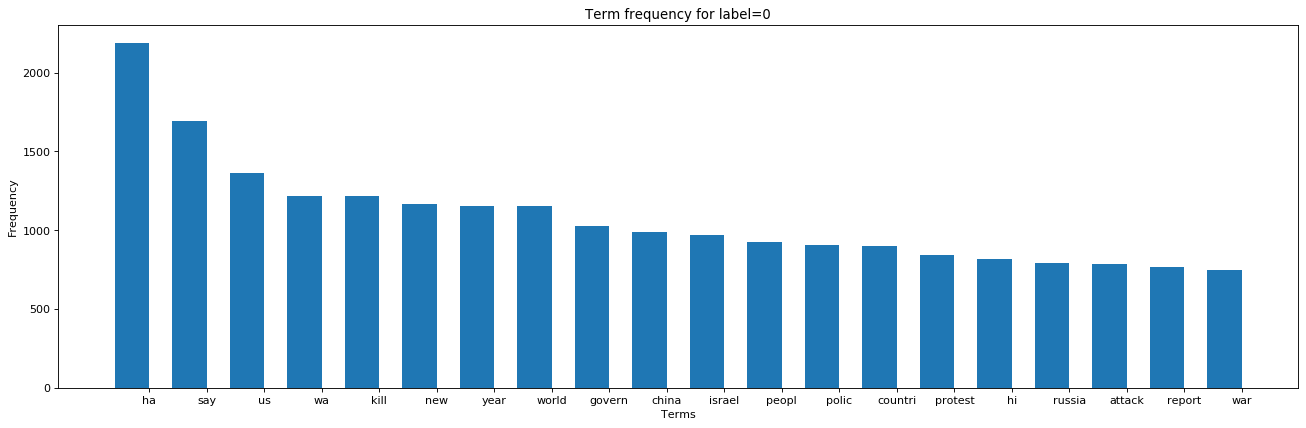

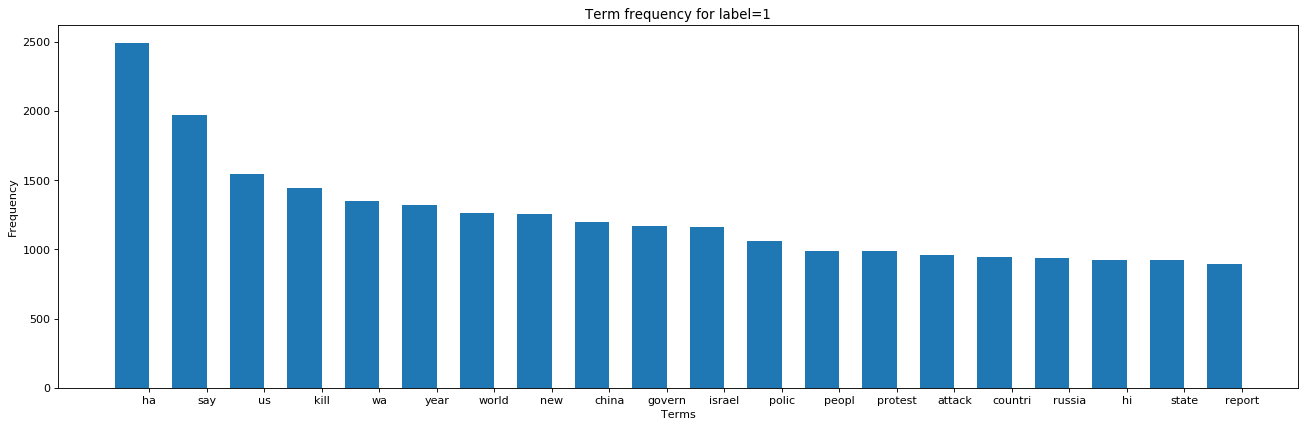

In [13]:
#get best 20 words
label_0 = dict(itertools.islice(label_0.items(),20))  
label_1= dict(itertools.islice(label_1.items(),20))  
#dict_label_0=pd.DataFrame.from_dict(label_0,orient='index')
#dict_label_1=pd.DataFrame.from_dict(label_1,orient='index')
def show_plt(dict,label):
    words = dict.keys()
    freq = [dict[word] for word in words]
    #print(freq)
    # Plot histogram using matplotlib bar().
    indexes = np.arange(len(words))
    width = 0.6
    figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.title("Term frequency for label="+label)
    plt.xlabel("Terms")
    plt.ylabel("Frequency")
    plt.bar(indexes, freq, width)
    plt.xticks(indexes + width * 0.5, words)
    plt.show()
    
show_plt(label_0,'0')
show_plt(label_1,'1')

#common between the 2 models:"ha","say","us","wa","kill","new","year","world","govern","israel","attack","report","people","polic","hi"

#### Split the data to train and test:

In [14]:
#join the titles under one column
X_not_combined=data_df.drop(['Label'], axis=1).drop(['Date'],axis=1)#without the label and the date
X=X_not_combined.apply(lambda x: " ".join(x), axis=1)#join all columns into one with " "
y=data_df['Label']
#split to test and train:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#### make another version of the data:

In [15]:
#v2-removing popular words that we found on Q1:
popular_words={"ha","say","us","wa","kill","new","year","world","govern","israel","attack","report","people","polic","hi"}
X_train_v2=[]
for line in X_train:
    new_line=[w for w in line.split() if not w in popular_words]
    X_train_v2.append(" ".join(new_line))
X_test_v2=[]
for line in X_test:
    new_line=[w for w in line.split() if not w in popular_words]
    X_test_v2.append(" ".join(new_line))

#### Vectorize:

In [64]:
#vectorize with count vectorizer the regular version
vectorizer=CountVectorizer(stop_words='english')
X_train_regular=vectorizer.fit_transform(X_train).toarray()
X_test_regular=vectorizer.transform(X_test).toarray()

#vectorize with count vectorizer the version without the common words
vectorizer_v2=CountVectorizer(stop_words='english')
X_train_no_common=vectorizer_v2.fit_transform(X_train_v2).toarray()
X_test_no_common=vectorizer_v2.transform(X_test_v2).toarray()

#vectorize the data with tf-idf vectorizer. we will use it to the Deep learning model:
vectorizer_LSTM=TfidfVectorizer(sublinear_tf=True,stop_words='english')
X_Train_tfidf_regular=vectorizer_LSTM.fit_transform(X_train)
X_Test_tfidf_regular=vectorizer_LSTM.transform(X_test)

#vectorize the data without the common words with tf-idf vectorizer. we will use it to the Deep learning model too:
vectorizer_LSTM_v2=TfidfVectorizer(sublinear_tf=True,stop_words='english')
X_Train_tfidf_no_common=vectorizer_LSTM.fit_transform(X_train_v2)
X_Test_tfidf_no_common=vectorizer_LSTM.transform(X_test_v2)

## Model Learning:

#### SVM-the regular data

In [19]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_train_regular, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

#### SVM- data with no common words

In [20]:
SVM2 = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM2.fit(X_train_no_common, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

#### Non linear SVM- the regular data

In [21]:
NLSVM = svm.NuSVC(gamma='auto')
NLSVM.fit(X_train_regular, y_train)

NuSVC(break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, nu=0.5, probability=False, random_state=None, shrinking=True,
      tol=0.001, verbose=False)

#### Non linear SVM- data with no common words

In [22]:
NLSVM2 = svm.NuSVC(gamma='auto')
NLSVM2.fit(X_train_no_common, y_train)

NuSVC(break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, nu=0.5, probability=False, random_state=None, shrinking=True,
      tol=0.001, verbose=False)

#### neural network - the regular data

In [25]:
#LSTM Model:

#build the model:
top_words=10000
embedding_vecor_length = 8
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
print(model.summary())

#train:
print("model.fit starting")
model.fit(X_Train_tfidf_regular, y_train, validation_data=(X_Test_tfidf_regular, y_test), epochs=5, batch_size=32, verbose=1)
print("model.fit finished")


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 8)           80000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                5248      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 85,281
Trainable params: 85,281
Non-trainable params: 0
_________________________________________________________________
None
model.fit starting
Train on 1591 samples, validate on 398 samples
Epoch 1/5
1591/1591 [==============================] - 2534s 2s/sample - loss: 0.6913 - accuracy: 0.5292 - val_loss: 0.6935 - val_accuracy: 0.5151
Epoch 2/5
1591/1591 [==============================] - 2365s 1s/sample - loss: 0.6902 - accuracy: 0.5405 - val_loss: 0.6930 - val_accuracy: 0.5151
Epoch 3/5
1591/

#### neural network - data with no common words

In [26]:
#build the model- with no commom words:
top_words=10000
embedding_vecor_length = 8
model_no_common = Sequential()
model_no_common.add(Embedding(top_words, embedding_vecor_length))
model_no_common.add(LSTM(32))
model_no_common.add(Dense(1, activation='sigmoid'))
model_no_common.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
print(model_no_common.summary())

#train:
print("model.fit happens now")
model_no_common.fit(X_Train_tfidf_no_common, y_train, validation_data=(X_Test_tfidf_no_common, y_test), epochs=5, batch_size=32, verbose=1)
print("model.fit finished")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 8)           80000     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                5248      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 85,281
Trainable params: 85,281
Non-trainable params: 0
_________________________________________________________________
None
model.fit happens now
Train on 1591 samples, validate on 398 samples
Epoch 1/5
1591/1591 [==============================] - 2532s 2s/sample - loss: 0.6916 - accuracy: 0.5368 - val_loss: 0.6931 - val_accuracy: 0.5151
Epoch 2/5
1591/1591 [==============================] - 2628s 2s/sample - loss: 0.6902 - accuracy: 0.5405 - val_loss: 0.6935 - val_accuracy: 0.5151
Epoch 3/5
15

## Model Testing:

#### SVM-the regular data

In [62]:
#predict the labels on validation dataset
predictions_SVM = SVM.predict(X_test_regular)
print("Score for SVM model with regular data")
# Use accuracy_score function to get the accuracy
print("Accuracy Score: ",accuracy_score(predictions_SVM, y_test)*100,"%")
#Get AUC score:
AUC_score_SVM=metrics.roc_auc_score(y_test, predictions_SVM)
print("AUC Score:",AUC_score_SVM)

Score for SVM model with regular data
Accuracy Score:  51.005025125628144 %
AUC Score: 0.5093769745987615


#### SVM- data with no common words

In [65]:
# predict the labels on validation dataset
predictions_SVM2 = SVM2.predict(X_test_no_common)
print("Score for SVM model without the common words")
# Use accuracy_score function to get the accuracy
print("Accuracy Score: ",accuracy_score(predictions_SVM2, y_test)*100,"%")
#Get AUC score:
AUC_score_v2_SVM=metrics.roc_auc_score(y_test, predictions_SVM2)
print("AUC Score:",AUC_score_v2_SVM)

Score for SVM model without the common words
Accuracy Score:  53.015075376884425 %
AUC Score: 0.5293441172753697


#### Non linear SVM- the regular data

In [29]:
# predict the labels on validation dataset
predictions_NLSVM = NLSVM.predict(X_test_regular)
print("Score for non linear SVM model with regular data")
# Use accuracy_score function to get the accuracy
print("Accuracy Score: ",accuracy_score(predictions_NLSVM, y_test)*100,"%")
#Get AUC score:
AUC_score_NLSVM=metrics.roc_auc_score(y_test, predictions_NLSVM)
print("AUC Score:",AUC_score_NLSVM)

Score for non linear SVM model with regular data
Accuracy Score:  52.26130653266332 %
AUC Score: 0.522027044104638


#### Non linear SVM- data with no common words

In [30]:
# predict the labels on validation dataset
predictions_NLSVM2 = NLSVM2.predict(X_test_no_common)
print("Score for non linear SVM model without the common words")
# Use accuracy_score function to get the accuracy
print("Accuracy Score: %.2f%%",accuracy_score(predictions_NLSVM2, y_test)*100,"%")
#Get AUC score:
AUC_score_v2_NLSVM=metrics.roc_auc_score(y_test, predictions_NLSVM2)
print("AUC Score:",AUC_score_v2_NLSVM)

Score for non linear SVM model without the common words
Accuracy Score:  54.020100502512555 %
AUC Score: 0.5395551623910022


#### neural network - the regular data

In [66]:
scores = model.evaluate(X_Test_tfidf_regular, y_test, verbose=0) #verbose for visualiztion of the output, can be either 0 or 1 or 2 
print("Score for LSTM model with regular data")
print("Accuracy Score: ",scores[1]*100,"%") #scores[0] is the loss of the model
y_pred_LSTM = model.predict(X_Test_tfidf_regular).ravel()
AUC_score_LSTM=metrics.roc_auc_score(y_test, y_pred_LSTM)
print("AUC Score:",AUC_score_LSTM)

Score for LSTM model with regular data
Accuracy Score:  51.50753855705261 %
AUC Score: 0.5


#### neural network - data with no common words

In [67]:
scores = model_no_common.evaluate(X_Test_tfidf_no_common, y_test, verbose=0) #verbose for visualiztion of the output, can be either 0 or 1 or 2 
print("Score for LSTM model without the common words")
print("Accuracy Score: ",scores[1]*100,"%") #scores[0] is the loss of the model
y_pred_LSTM = model_no_common.predict(X_Test_tfidf_no_common).ravel()
AUC_score_LSTM=metrics.roc_auc_score(y_test, y_pred_LSTM)
print("AUC Score:",AUC_score_LSTM)

Score for LSTM model without the common words
Accuracy Score:  51.50753855705261 %
AUC Score: 0.4995450524453431


## Reddit Crawler

#### connect to reddit:

In [36]:
import praw
import pandas as pd
import datetime as dt

#reddit = praw.Reddit(client_id='PERSONAL_USE_SCRIPT_14_CHARS', 
#                    client_secret='SECRET_KEY_27_CHARS ', 
#                     user_agent='YOUR_APP_NAME', 
#                     username='YOUR_REDDIT_USER_NAME', 
#                    password='YOUR_REDDIT_LOGIN_PASSWORD')


    
reddit = praw.Reddit(client_id='StvAnZnEcUAiyw', 
                 client_secret='T-8EmAGPruL1rjqp5WbdPfaZfcs', 
                 user_agent='DJIA_predict', 
                 username='Inbaroth', 
                 password='Inbar12345')


#### Data Collection - collecting past 10 days "world news" from Reddit:

In [37]:
#Posts of last month:

worldnews=[]
for submission in reddit.subreddit('worldnews').top('month', limit=1000):
    worldnews.append(submission)
        

In [38]:
#Posts of last 10 days:

filtered_news = pd.DataFrame()
news_titles = []
publish_date = []

start_date_unix = 1581811200 #16/02/2020 in unix
end_date_unix = 1582675200 #26/02/202 in unix

for post in worldnews:
  if(start_date_unix < post.created_utc < end_date_unix):  
    news_titles.append(post.title.encode('ascii', 'ignore'))
    publish_date.append(dt.datetime.fromtimestamp(post.created).strftime('%d/%m/%Y'))

filtered_news['Title'] = news_titles
filtered_news['Date'] = publish_date

print(filtered_news)

                                                 Title        Date
0    b'The family of a British teenager killed in a...  24/02/2020
1    b'Julian Assange says he was promised a Trump ...  20/02/2020
2    b'President Trump is apparently not a fan of B...  21/02/2020
3    b'China bans human consumption and trade of wi...  25/02/2020
4    b"Iran Says US Must Fix Its Own 'Nontransparen...  18/02/2020
..                                                 ...         ...
325  b'Mecca governor orders arrest of Saudi female...  24/02/2020
326  b'Woman Threw Apple at Netanyahu During Electi...  16/02/2020
327  b'14 children among 22 murdered in brutal Came...  17/02/2020
328  b'Coronavirus far deadlier than normal flu, ne...  18/02/2020
329  b'Italy cancels last day of Venice festival ov...  23/02/2020

[330 rows x 2 columns]


In [39]:
#Each day - 25 news:

news_df = {}

# print filtered
for index, row in filtered_news.iterrows():
    date = row['Date']
    
    if date not in news_df:
         news_df[date] = []
    
    if not (len(news_df[date]) >= 25):
        news_df[date].append(row['Title'])
news_df = pd.DataFrame.from_dict(news_df, orient='index').sort_index()


#### Pre-processing: implement tokinization & stemming on Reddit data:

In [40]:
stop_index = news_df.columns.stop

if(stop_index < 25):
    headlines_columns = news_df.columns[range(0, stop_index)]
else:
    headlines_columns = news_df.columns[range(0, 25)]
news_df[headlines_columns] = news_df[headlines_columns].applymap(preprocessing)


In [41]:
from bs4 import BeautifulSoup
import urllib
import urllib.request as req
import requests

#### Data Collection - Collect DJIA Data from Yahoo! Finance:

In [42]:
yahoo_html = requests.get("https://finance.yahoo.com/quote/%5EDJI/history?p=%5EDJI", verify=False).text
soup = BeautifulSoup(yahoo_html)

DJIA_table = pd.read_html(str(soup.find("table", class_="W(100%) M(0)")), header=0)[0]
DJIA_table = DJIA_table.head(10)

C:\Users\Inbar\Anaconda3\envs\tensorflow_env\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'finance.yahoo.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


In [43]:
#get Labels from Yahoo:

dates = []
labels = []

for index, row in DJIA_table.iterrows():
    open = row['Open']
    close = row['Close*']
    
    #DJIA not increasing:
    if(open > close):
        labels.append(0)
    
    #DJIA increasing:
    else:
        labels.append(1)
    dates.append(dt.datetime.strptime(row['Date'], '%b %d, %Y').strftime('%d/%m/%Y'))

DJIA_labeled_df = pd.DataFrame()
DJIA_labeled_df['Date'] = dates
DJIA_labeled_df['Label'] = labels

In [44]:
# join Reddit news and Yahoo labels by date:

labeled_news_data = pd.merge(DJIA_labeled_df[["Date", "Label"]], news_df, left_on="Date", right_index=True)

In [46]:
X_Test_Reddit = labeled_news_data.drop(['Label','Date'], axis=1)
y_test_Yahoo = labeled_news_data[["Label"]]
X_Test_Reddit = X_Test_Reddit.apply(lambda x: " ".join(x), axis=1).tolist()

#### Reddit's data exploration

In [56]:
#class distribution
classCounter = {}
classCounter[0]=0
classCounter[1]=0
for label in y_test_Yahoo['Label']:
    classCounter[label]+=1
print("class distribution:")
pd.DataFrame.from_dict(classCounter,orient='index',columns=['number of Samples'])

class distribution:


,number of Samples
0,6
1,1


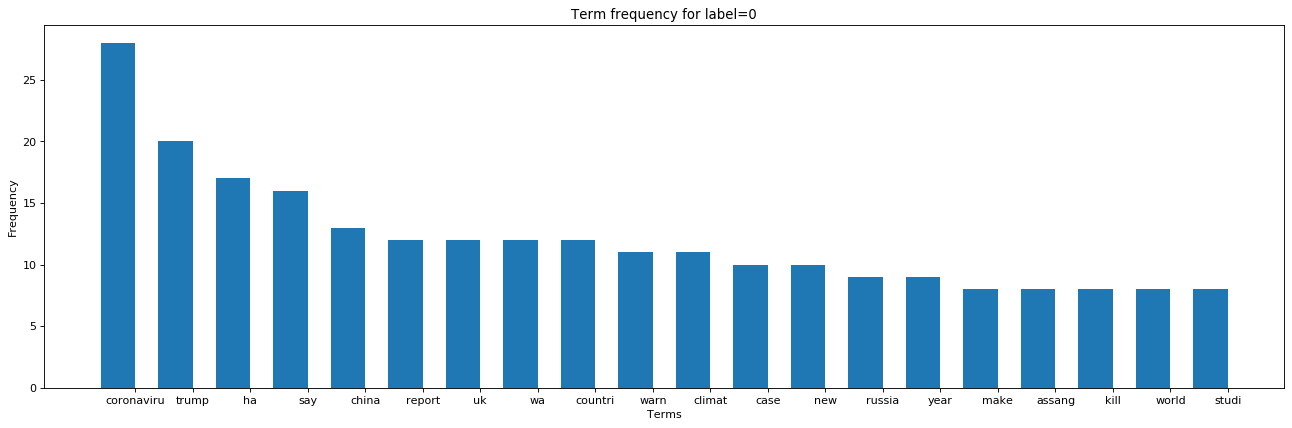

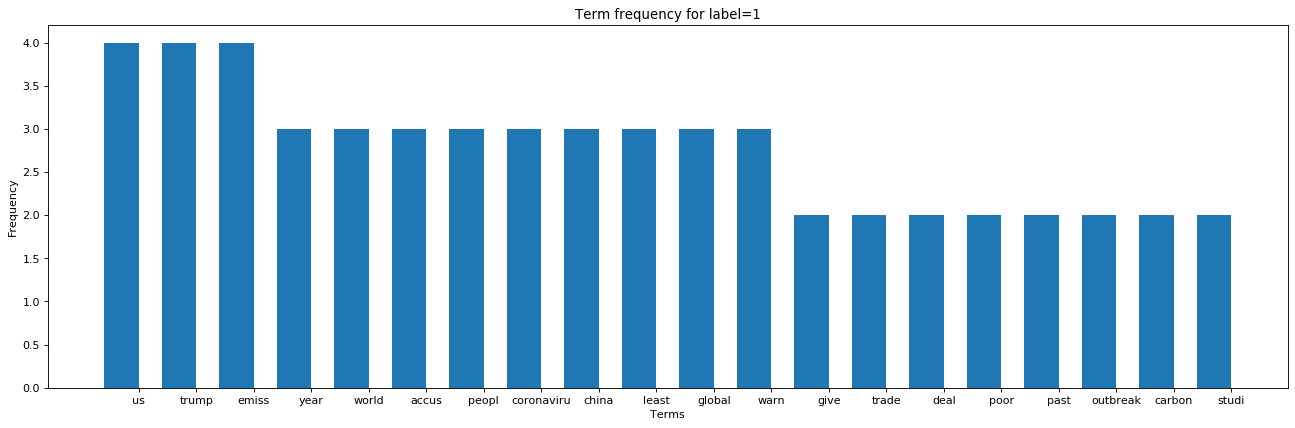

In [57]:
#terms frequency for each class
#build dictionary of class:{term:frequency}
terms_dict={}
terms_dict[0]={}
terms_dict[1]={}
i=0
for news in X_Test_Reddit:
    label=y_test_Yahoo['Label'][i]
    i+=1
    tokens=word_tokenize(news)
    for token in tokens:
        if token not in terms_dict[label]:
            terms_dict[label][token]=0
        terms_dict[label][token]+=1
label_0={key: value for key, value in sorted(terms_dict[0].items(), key=lambda item: item[1],reverse=True)}
label_1={key: value for key, value in sorted(terms_dict[1].items(), key=lambda item: item[1],reverse=True)}
#get best 20 words
label_0 = dict(itertools.islice(label_0.items(),20))  
label_1= dict(itertools.islice(label_1.items(),20))  
   
show_plt(label_0,'0')
show_plt(label_1,'1')

#### vectorize 

In [51]:
#vectorize with count vectorizer the version without the common words
X_Test_Reddit_no_common=vectorizer_v2.transform(X_Test_Reddit).toarray()

### Predict with best model: Non linear SVM- data with no common words

In [54]:
# predict the labels on validation dataset
predictions_NLSVM2 = NLSVM2.predict(X_Test_Reddit_no_common)
print("Score for non linear SVM model without the common words")
# Use accuracy_score function to get the accuracy
print("Accuracy Score: ",accuracy_score(predictions_NLSVM2, y_test_Yahoo)*100,"%")
#Get AUC score:
AUC_score_v2_NLSVM=metrics.roc_auc_score(y_test_Yahoo, predictions_NLSVM2)
print("AUC Score:",AUC_score_v2_NLSVM)

Score for non linear SVM model without the common words
Accuracy Score:  42.857142857142854 %
AUC Score: 0.25
